# Using bartiq for Resource Analysis

<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>

This tutorial, as well as all the other tutorials, has been written as a jupyter notebook.
If you're reading it online, you can either keep reading, or clone the repository and go to `docs/tutorials` to explore them in a more interactive way!

</div>

It is time to explore how to use `bartiq`'s resource estimation capabilities in practical quantum algorithm analysis. In this tutorial, you will:

- Compare resources of different implementations of the same operation/unitary using `bartiq`.
- Transform your estimate to obtain more useful information about the problem.
- Learn how to implement nested hierarchy in `bartiq`.


In the [previous tutorial](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/), we demonstrated how the alias sampling algorithm works, along with its subroutines - USP, $H^{\otimes\mu}$, QROM, comparator, and controlled SWAP. Beyond the uniform state preparation (USP) method introduced in tutorial 02, several other USP implementations are worth considering as alternatives. You can think of these implementations as interchangeable quantum circuits。

In this tutorial we will see if we can make alias sampling use less resources by using a different implementation of USP. 

### USP Implementations

Let's start by setting up different USP routines in `bartiq`.

We will analyze three distinct uniform state preparation routines:

1. **USP**: The basic uniform state preparation routine introduced in [Encoding Electronic Spectra...](https://arxiv.org/abs/1805.03662), also the one used in [tutorial 02](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/).
2. **ZeroAncillaUSP**: A more recent construction that eliminates the need for any ancilla qubits, as presented in [An efficient quantum algorithm for preparation of uniform quantum superposition states](https://arxiv.org/abs/2306.11747).
3. **RUS_USP**:  A variation of the method described in [Encoding Electronic Spectra...](https://arxiv.org/abs/1805.03662), using Repeat-Until-Success approach.

Throughout this notebook, we will refer to these routines as `USP`, `ZeroAncillaUSP` and `RSU_USP` respectively. 

<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>

This tutorial is not meant to provide definitive expressions. Instead, it is designed to guide you through relevant sections of the papers, obtain expressions and use them to demonstrate how `bartiq` works. If you find any mistakes or oversimplifications, please let us know!

Additionally, future work may reveal that not all cost estimates are accurate, as some routines can be optimized further. However, explaining these optimizations is beyond the scope of this tutorial.

</div>

## USP

The implementation of the `USP` method in [Encoding Electronic Spectra...](https://arxiv.org/abs/1805.03662) has been described in [tutorial 02](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/). Let's do a quick recap.

### Parameters

To prepares a state which is a uniform superposition over $L$ basis states:

- $L$: Number of coefficients we want to load.
- $k$: The largest integer such that $2^k$ divides $L$ , $k = \textrm{multiplicity}(2, L)$.

Note: These expressions only valid if $L$ is not a power of two, as in such case we can trivially implement USP using a layer of Hadamard gates.

Here, we will break down the `USP` routine into more detailed operations, including the inequality test, rotation, (uncompute) inequality test, and a (controlled) rotation. Since these operations are not run in parallel nor share qubits at the same time, representing each individual subroutine is straightforward and intuitive. Below is the circuit diagram for the USP, adapted from Figure 12 of the original paper:

![USP](../images/usp.png)


In [1]:
def generate_inequality_test(name):
    return {
        "name": name,
        "type": None,
        "ports": [
            {"name": "in", "direction": "input", "size": "R"},
            {"name": "out", "direction": "output", "size": "R"},
        ],
        "resources": [
            {
                "name": "T_gates",
                "type": "additive",
                "value": "4*ceiling(log_2(L/(2 ** k))-1)",
            },
        ],
        "input_params": ["L"],
        "local_variables": {"R": "ceiling(log_2(L))", "k": "multiplicity(2,L)"},
    }

In [2]:
def generate_rotation(name):
    return {
        "name": name,
        "type": None,
        "ports": [
            {"name": "in", "direction": "input", "size": "R"},
            {"name": "out", "direction": "output", "size": "R"},
        ],
        "resources": [
            {"name": "rz", "type": "additive", "value": "1"},
        ],
        "input_params": ["L"],
        "local_variables": {"R": "ceiling(log_2(L))"},
    }

In [3]:
def generate_controlled_rotation(name):
    return {
        "name": name,
        "type": None,
        "ports": [
            {"name": "in", "direction": "input", "size": "R"},
            {"name": "out", "direction": "output", "size": "R"},
        ],
        "resources": [
            {"name": "rz", "type": "additive", "value": "1"},
            # 2* (log_2(L/(2 ** k))-1) Toffoli gates
            {
                "name": "T_gates",
                "type": "additive",
                "value": "4*ceiling(log_2(L/(2 ** k))-1)",
            },
        ],
        "input_params": ["L"],
        "local_variables": {"R": "ceiling(log_2(L))", "k": "multiplicity(2,L)"},
    }

The dictionary for the entire algorithm is shown below. You might notice that, compared to the previous tutorial, we have introduced ancilla qubits as a new resource here. Yes, ancilla qubits can be considered a resource just like quantum gates. We include ancilla qubits in the overall USP routine, rather than in the subroutines, because the two inequality tests operate on the same set of ancillas. Additionally, we're considering reallocating the ancillas for the subsequent controlled rotation. We use type `qubits` for them, though at the moment Bartiq does not handle this type in any special way.

Also, please note that these are arbitrary choices –  you might want to experiment a bit to see which setup works best in your case.

In [4]:
usp_dict = {
    "name": "usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "children": [
        generate_inequality_test("inequality_test_1"),
        generate_rotation("rotation_1"),
        generate_inequality_test("inequality_test_2"),
        generate_controlled_rotation("rotation_2"),
    ],
    "input_params": ["L"],
    "local_variables": {"R": "ceiling(log_2(L))", "k": "multiplicity(2,L)"},
    "connections": [
        {"source": "in", "target": "inequality_test_1.in"},
        {"source": "inequality_test_1.out", "target": "rotation_1.in"},
        {"source": "rotation_1.out", "target": "inequality_test_2.in"},
        {"source": "inequality_test_2.out", "target": "rotation_2.in"},
        {"source": "rotation_2.out", "target": "out"},
    ],
    "resources": [
        {
            "name": "ancilla",
            "type": "qubits",
            "value": "floor(log_2(L/2 ** k))",
        },
    ],
    "linked_params": [
        {"source": "L", "targets": ["inequality_test_1.L", "rotation_1.L", "inequality_test_2.L", "rotation_2.L"]},
    ],
}

In [5]:
usp = {"version": "v1", "program": usp_dict}

### Visualizion of the `USP` routine

<div class="alert alert-block alert-info admonition note">
    <p class="admonition-title"><b>NOTE:</b></p>
    <p>
        To use the <a href="https://github.com/PsiQ/qref">qref</a> rendering tool in Jupyter Notebook, ensure the Graphviz software is installed on your OS and that its executables are included in your system variables. For installation instructions, please refer to the <a href="https://graphviz.org/download/">Graphviz download page</a>.
    </p>
</div>

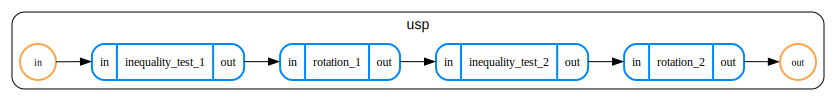

In [6]:
from qref.experimental.rendering import to_graphviz

# Convert the qref format to Graphviz object
gv_object = to_graphviz(usp)

# Render the Graphviz object to a PNG file
gv_object.render("usp", format="png")
gv_object

and if we use this usp_dict to replace the usp in [previous tutorial](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/)'s alias sampling example, we'll have the alias sampling with more detailed hierarchy, like this: 

In [7]:
import json

# Load the alias sampling file
with open("../data/alias_sampling_basic.json", "r") as f:
    as_data = json.load(f)

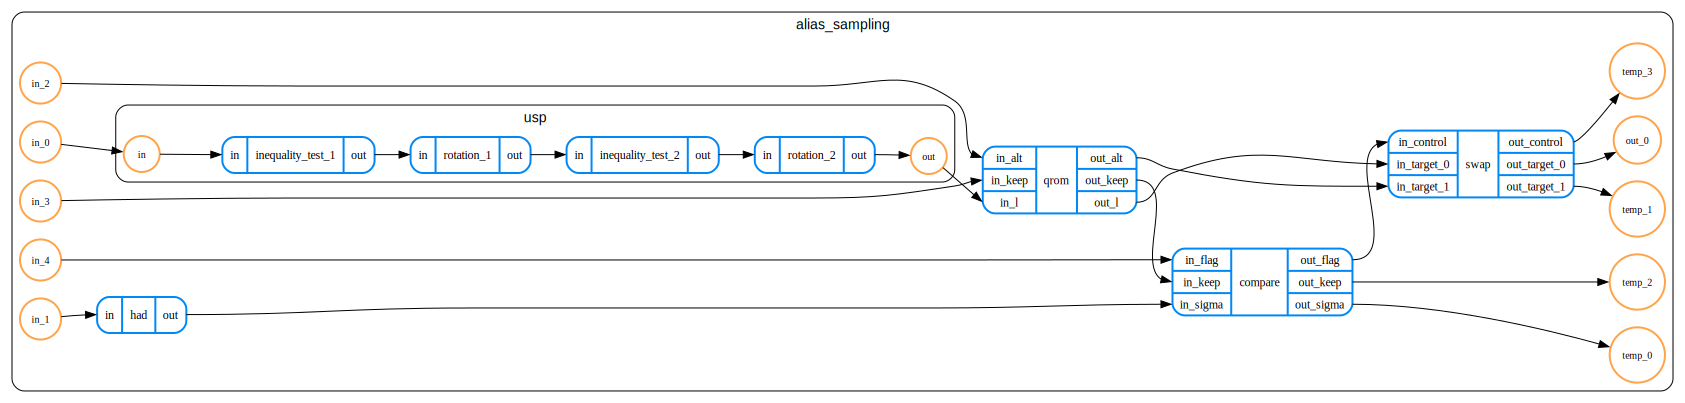

In [8]:
as_qref = as_data.copy()
for i, child in enumerate(as_qref["program"]["children"]):
    if child["name"] == "usp":
        as_qref["program"]["children"][i] = usp_dict

# Convert the qref format to Graphviz object
gv_object = to_graphviz(as_qref)

# Render the Graphviz object to a PNG file
gv_object.render("alias_nested", format="png")
gv_object

Anyway, let's come back to the compilation process of `USP` in `bartiq`. 

In [9]:
from bartiq.integrations import qref_to_bartiq

uncompiled_usp = qref_to_bartiq(usp)

In the definition of rotation, we used `rz` as the resource.

Here, we can use `add_aggregated_resources` function to decompose the `rz` gates into more fundamental, general non-Clifford gates. This function takes a dictionary that specifies how to decompose the gates and an uncompiled bartiq routine as parameters. It synthesizes all matching resources within the bartiq routine according to the dictionary. 

In this context, we approximate $R_z(\theta)$ gates using an approximation of 50 T gates base on the approximation from [Efficient Clifford+T approximation of single-qubit operators](https://arxiv.org/abs/1212.6253) with error threshold $\epsilon = 0.001$. The exact number will depend on the desired accuracy of the approximation, but 50 T gates will be a good choice for many applications.

In [10]:
from bartiq.transform import add_aggregated_resources

aggregation_dict = {"rz": {"T_gates": 50}}
aggregated_uncompiled_usp = add_aggregated_resources(uncompiled_usp, aggregation_dict)
# Note that aggregation removed the `rz` resources:
print(aggregated_uncompiled_usp.children["rotation_1"].resources)

{'T_gates': <Resource name="T_gates" value="50">}


Here is the final result of our resource estimation for the `USP` routine, contains only T gates and ancilla qubits:

In [11]:
from bartiq import compile_routine

compiled_usp = compile_routine(aggregated_uncompiled_usp)
for resource in compiled_usp.resources.values():
    print(f"{resource.name}: {resource.value}")

ancilla: floor(log2(L/2 ^ multiplicity(2, L)))
T_gates: 12*ceiling(log2(L/2 ^ multiplicity(2, L))) + 88


### Numerical Evaluation Examples

In [12]:
from bartiq import evaluate

values = [3, 5, 6, 7, 9, 10, 12, 14, 15]
assignments_list = [[f"L={value}"] for value in values]

for assignments in assignments_list:
    evaluated_usp = evaluate(compiled_usp, assignments)
    print(f"Assignment: {assignments[0]}")
    for resource in evaluated_usp.resources.values():
        print(f"  {resource.name}: {resource.value}")

Assignment: L=3
  ancilla: 1
  T_gates: 112
Assignment: L=5
  ancilla: 2
  T_gates: 124
Assignment: L=6
  ancilla: 1
  T_gates: 112
Assignment: L=7
  ancilla: 2
  T_gates: 124
Assignment: L=9
  ancilla: 3
  T_gates: 136
Assignment: L=10
  ancilla: 2
  T_gates: 124
Assignment: L=12
  ancilla: 1
  T_gates: 112
Assignment: L=14
  ancilla: 2
  T_gates: 124
Assignment: L=15
  ancilla: 3
  T_gates: 136


## Zero Ancilla USP

[An efficient quantum algorithm for preparation of uniform quantum superposition states](https://arxiv.org/abs/2306.11747)  provides an alternative approach to USP that eliminates the need for ancilla qubits while maintaining similar asymptotic scaling to the other approach. We will refer to this as the `ZeroAncillaUSP`. The gate count for this method is detailed in Section 2.5 of the paper. Here, we will focus on the non-Clifford gate overhead and ignore the Clifford costs.

To create a uniform superposition of $ L $ basis states using the `ZeroAncillaUSP` method, the following non-Clifford gate overhead is required:

### Non-Clifford Gate Overhead

- $R_Y (\theta)$ gate: 1.
- Controlled Hadamard gate: $l_k - l_0$.
- Controlled-$R_Y (\theta)$ gate: $k - 1$.

### Parameters

- $l_0, l_1, \ldots, l_k$: This is a sequence of integers where $L = \sum_{j=0}^k 2^{l_j}$ and $0 \le l_0 < l_1 < \ldots < l_{k-1} < l_k \le n-1$. In simpler terms:
  - $l_0$ is the position of the trailing zero in the binary representation of $L$.
  - $l_k$ is the position of the highest set bit, or $\lfloor \log_2(L) \rfloor$.
  - $k$ is the number of non-zero bits in the binary representation of $L$. Note: This is different from $k$ in `USP`.

Using these parameters, you can determine the specific gate overhead required for the `ZeroAncillaUSP` method in `bartiq`.


In [13]:
zeroanc_usp = {
    "name": "zeroanc_usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "input_params": ["L"],
    "local_variables": {
        "l_0": "trailing(L)",
        "R": "ceil(log2(L))",
        "l_k": "floor(log2(L))",
        "k": "bin_bitcount(L) - 1 ",
    },
    "resources": [
        {"name": "ry", "type": "additive", "value": "1"},
        {"name": "control_ry", "type": "additive", "value": "k - 1"},
        {"name": "control_H", "type": "additive", "value": "l_k - l_0"},
    ],
}

As you can see, we use custom functions `trailing` and `bin_bitcount` – that's fine, because Bartiq can handle arbitrary functions, but we'll also define them later.

In [14]:
zeroanc = {"version": "v1", "program": zeroanc_usp}

In [15]:
uncompiled_zeroanc = qref_to_bartiq(zeroanc)

Here is the resource expression for `ZeroAncillaUSP`:

In [16]:
for resource in uncompiled_zeroanc.resources.values():
    print(f"{resource.name}: {resource.value}")

control_H: l_k - l_0
control_ry: k - 1
ry: 1


Again, we decompose the `control_ry` and `control_H` gates to T gate approximations:
- control_ry: A controlled $R_Y (\theta)$ gate, which contains 2 ry gates after decomposition.
- control_H: A controlled Hadamard gate, contains 2 T gates after gate synthesis.
- $R_Y (\theta)$: A ry gate, similar to an rz gate, can be approximated by about 50 T gates with $\epsilon = 0.001$.


In [17]:
aggregation_dict = {"control_ry": {"ry": 2}, "control_H": {"T_gates": 2}, "ry": {"T_gates": 50}}
aggregated_zeroanc = add_aggregated_resources(uncompiled_zeroanc, aggregation_dict)

In [18]:
compiled_zeroanc = compile_routine(aggregated_zeroanc)
for resource in compiled_zeroanc.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: 100*bin_bitcount(L) - 2*trailing(L) + 2*floor(log2(L)) - 150


### Numerical Evaluation Examples

In [19]:
import sympy


def trailing(x):
    return sympy.trailing(x)


def bin_bitcount(x):
    return bin(x).count("1")


functions_map = {"trailing": trailing, "bin_bitcount": bin_bitcount}
values = [3, 5, 6, 7, 9, 10, 12, 14, 15]
assignments_list = [[f"L={value}"] for value in values]

for assignments in assignments_list:
    evaluated_zeroanc = evaluate(compiled_zeroanc, assignments, functions_map=functions_map)
    print(f"Assignment: {assignments[0]}")
    for resource in evaluated_zeroanc.resources.values():
        print(f"  {resource.name}: {resource.value}")

Assignment: L=3
  T_gates: 52
Assignment: L=5
  T_gates: 54
Assignment: L=6
  T_gates: 52
Assignment: L=7
  T_gates: 154
Assignment: L=9
  T_gates: 56
Assignment: L=10
  T_gates: 54
Assignment: L=12
  T_gates: 52
Assignment: L=14
  T_gates: 154
Assignment: L=15
  T_gates: 256


## Repeat-Until-Success (RUS) USP

As a variation of the method described in [Encoding Electronic Spectra...](https://arxiv.org/abs/1805.03662), we introduce another approach to state preparation using inequality tests, known as the Repeat-Until-Success (RUS) USP.

## What is RUS?

The Repeat-Until-Success (RUS) method is a probabilistic technique where attempts are repeatedly made until a successful result is achieved. Failed attempts are discarded, and only the final successful state is retained. Comparing to the method described in [Encoding Electronic Spectra...](https://arxiv.org/abs/1805.03662), `RUS_USP` omits the amplitude amplification step, but requires a non-deterministic number of repetitions.


## Resource Estimation for Repetition
Below, we symbolically estimate the resources required for `RUS_USP`:

In [20]:
rus_usp = {
    "name": "rus_usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "input_params": ["L"],
    "local_variables": {"k": "multiplicity(2,L)", "R": "ceiling(log_2(L))", "trial": "num_iter(L)"},
    "resources": [
        {"name": "T_gates", "type": "additive", "value": "4*trial*ceil(log_2(L/(2 ** k))-1)"},
        {"name": "ancilla", "type": "additive", "value": "floor(log_2(L/2 ** k))"},
    ],
}

In [21]:
rus = {"version": "v1", "program": rus_usp}

In [22]:
uncompiled_rus = qref_to_bartiq(rus)
compiled_rus = compile_routine(uncompiled_rus)

for resource in compiled_rus.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: 4*(ceiling(log2(L/2 ^ multiplicity(2, L))) - 1)*num_iter(L)
ancilla: floor(log2(L/2 ^ multiplicity(2, L)))


This estimation arises because it is equivalent to performing two cost inequality tests. Each test has a Toffoli gate count of $\lceil \log_2 \left(L/2^k\right) \rceil - 1$. According to [Halving the cost of quantum addition](https://arxiv.org/abs/1709.06648), when the input of the target is known to be in $| 0 \rangle$, each Toffoli gate can be decomposed into 4 T gates. Additionally, the T gate cost for the uncompute inequality test (the second one) can be ignored.

Now let's look at how to calculate `num_iter(L)`.

### Repetition Number

The probability of success in each trial is determined by the ratio of $L$ to the smallest power of 2 that is greater than or equal to  $L$.
This function  below provides a rough estimation of the number of trials needed to achieve a target success probability (default is 99%) based on the geometric distribution. This means it may not match the actual number of trials required each time, as the process is probabilistic, but gives us the estimation for an average case.

Here's how you can estimate the number of trials:

In [23]:
import math


def calculate_trials(d, target_probability=0.99):
    prob = d / (1 << math.ceil(math.log2(d)))
    return math.ceil(math.log(1 - target_probability) / math.log(1 - prob))

In [24]:
L = 7
num_trials = calculate_trials(7)
print(f"For L={L}, the estimated number of trials needed is: {num_trials}")

For L=7, the estimated number of trials needed is: 3


### Total Resource Estimation
By combining the estimated repetition number with the resource estimation for a single repetition, we can do the numeric evaluation of the total resources required.

In [25]:
values = [3, 5, 6, 7, 9, 10, 12, 14, 15]
assignments_list = [[f"L={value}"] for value in values]

functions_map = {"num_iter": calculate_trials}

for assignments in assignments_list:
    evaluated_rus = evaluate(compiled_rus, assignments, functions_map=functions_map)
    print(f"Assignment: {assignments[0]}")
    for resource in evaluated_rus.resources.values():
        print(f"  {resource.name}: {resource.value}")

Assignment: L=3
  T_gates: 16
  ancilla: 1
Assignment: L=5
  T_gates: 40
  ancilla: 2
Assignment: L=6
  T_gates: 16
  ancilla: 1
Assignment: L=7
  T_gates: 24
  ancilla: 2
Assignment: L=9
  T_gates: 72
  ancilla: 3
Assignment: L=10
  T_gates: 40
  ancilla: 2
Assignment: L=12
  T_gates: 16
  ancilla: 1
Assignment: L=14
  T_gates: 24
  ancilla: 2
Assignment: L=15
  T_gates: 24
  ancilla: 3


## Comparison

Now, we can compare the cost performance of different USP methods for some concrete data.

### Make the Samples

Here, we generate some instances that are not powers of 2 (when $L$ is a power of 2, only Hadamard gates are needed).

In [26]:
def is_power_of_two(n):
    return (n & (n - 1) == 0) and n != 0


all_values = [x for x in range(5, 600) if not is_power_of_two(x)]
L_values = all_values

### Resource Estimation

In [27]:
# USP
usp_tgates = []
usp_ancilla = []

for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_usp = evaluate(compiled_usp, assignments_list)
    usp_tgates.append(math.ceil(float(evaluated_usp.resources["T_gates"].value)))
    if "ancilla" in evaluated_usp.resources:
        usp_ancilla.append(int(evaluated_usp.resources["ancilla"].value))
    else:
        usp_ancilla.append(0)

In [28]:
# Zeroanc_USP
zeroanc_tgates = []
zeroanc_ancilla = []

functions_map = {"trailing": trailing, "bin_bitcount": bin_bitcount}

for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_zeroanc = evaluate(compiled_zeroanc, assignments_list, functions_map=functions_map)
    zeroanc_tgates.append(int(evaluated_zeroanc.resources["T_gates"].value))
    if "ancilla" in evaluated_zeroanc.resources:
        zeroanc_ancilla.append(int(evaluated_zeroanc.resources["ancilla"].value))
    else:
        zeroanc_ancilla.append(0)

In [29]:
# RUS_USP
rus_tgates = []
rus_ancilla = []

functions_map = {"num_iter": calculate_trials}

for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_rus = evaluate(compiled_rus, assignments_list, functions_map=functions_map)
    rus_tgates.append(int(evaluated_rus.resources["T_gates"].value))
    if "ancilla" in evaluated_rus.resources:
        rus_ancilla.append(int(evaluated_rus.resources["ancilla"].value))
    else:
        rus_ancilla.append(0)

## Plotting the Result of T_gates

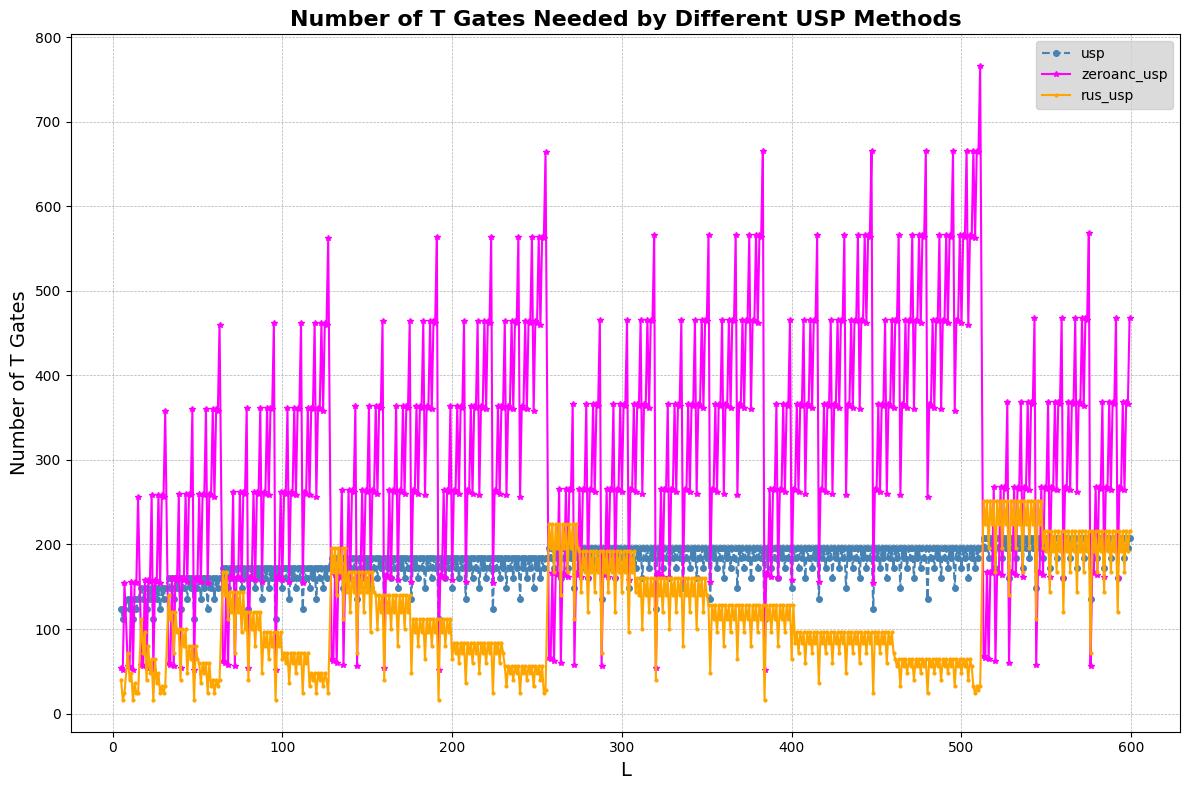

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.plot(L_values, usp_tgates, label="usp", marker="o", color="steelblue", markersize=4, linestyle="--")
plt.plot(L_values, zeroanc_tgates, label="zeroanc_usp", marker="*", color="magenta", markersize=4, linestyle="-")
plt.plot(L_values, rus_tgates, label="rus_usp", marker=".", color="orange", markersize=4, linestyle="-")

plt.title("Number of T Gates Needed by Different USP Methods", fontsize=16, fontweight="bold")
plt.xlabel("L", fontsize=14)
plt.ylabel("Number of T Gates", fontsize=14)

plt.legend(title="Methods", fontsize=12, title_fontsize="13", loc="upper left", frameon=True, edgecolor="black")
plt.legend().get_frame().set_facecolor("lightgrey")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

## Plotting the Results of Ancilla Qubits

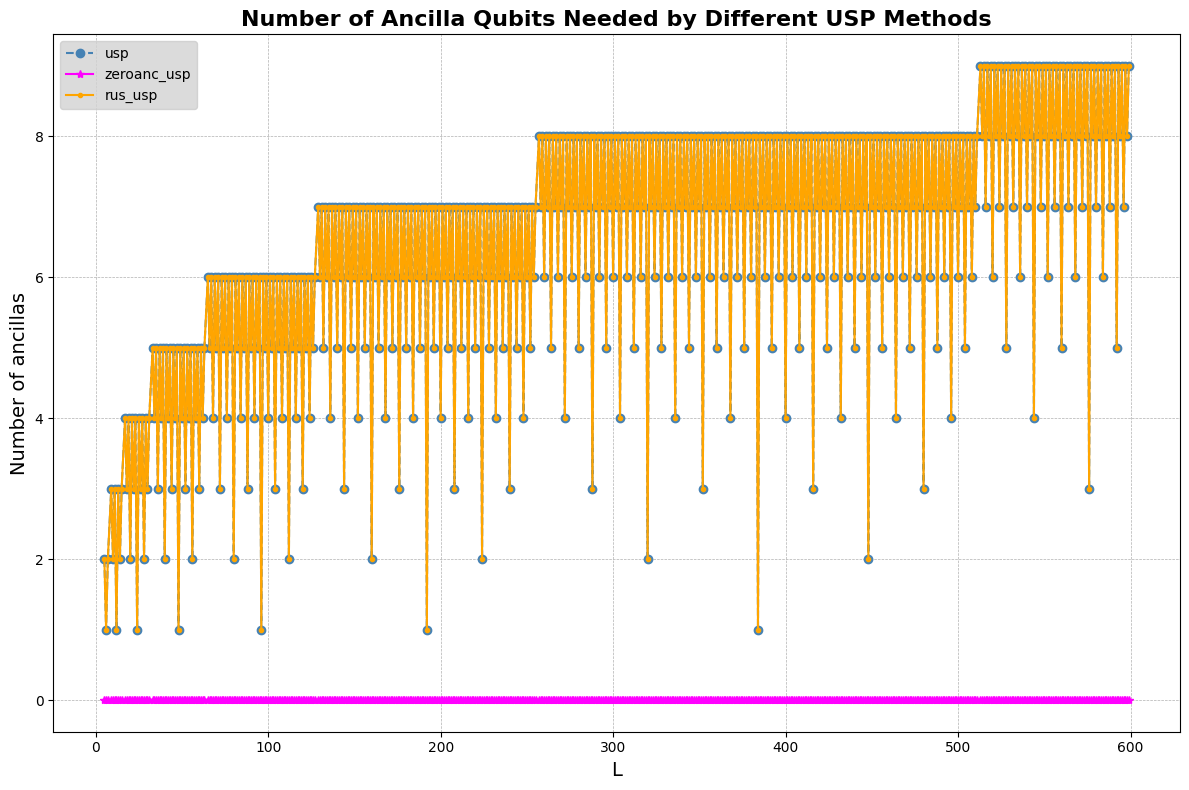

In [31]:
plt.figure(figsize=(12, 8))

plt.plot(L_values, usp_ancilla, label="usp", marker="o", color="steelblue", markersize=6, linestyle="--")
plt.plot(L_values, zeroanc_ancilla, label="zeroanc_usp", marker="*", color="magenta", markersize=6, linestyle="-")
plt.plot(L_values, rus_ancilla, label="rus_usp", marker=".", color="orange", markersize=6, linestyle="-")

plt.title("Number of Ancilla Qubits Needed by Different USP Methods", fontsize=16, fontweight="bold")
plt.xlabel("L", fontsize=14)
plt.ylabel("Number of ancillas", fontsize=14)

plt.legend(title="Methods", fontsize=12, title_fontsize="13", loc="upper left", frameon=True, edgecolor="black")
plt.legend().get_frame().set_facecolor("lightgrey")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

...and we leave the analysis up to you! Decide by yourself which USP implementation suits your needs best!

## Alias Sampling with Different USP

Finally, we'll explore integrating different USP expressions into Alias Sampling. By substituting various USP formulations, we'll see how these changes impact the overall expression and sampling results. 

In [32]:
# usp
uncompiled_as_usp = qref_to_bartiq(as_data)

aggregated_uncompiled_usp.name = "usp"
aggregated_uncompiled_usp.parent = uncompiled_as_usp
aggregated_uncompiled_usp.ports["out"].size = None

uncompiled_as_usp.children["usp"] = aggregated_uncompiled_usp

compiled_as_usp = compile_routine(uncompiled_as_usp, global_functions=["O"])

/Users/sliu/PycharmProjects/debugging/debugging/lib/python3.12/site-packages/bartiq/compilation/_compile.py:117: UserWarning: Found the following issues with the provided routine after the compilation has finished: ["Symbol P_2 found in subroutine: alias_sampling.swap.passthrough_2, which is not among top level params: {'mu', 'R', 'L'}.", "Symbol P_1 found in subroutine: alias_sampling.swap.passthrough_1, which is not among top level params: {'mu', 'R', 'L'}.", "Symbol P_2 found in subroutine: alias_sampling.swap, which is not among top level params: {'mu', 'R', 'L'}."]
  warnings.warn(


In [33]:
# zeroanc_usp
uncompiled_as_zeroanc = qref_to_bartiq(as_data)

aggregated_zeroanc.name = "usp"
aggregated_zeroanc.parent = uncompiled_as_zeroanc

uncompiled_as_zeroanc.children["usp"] = aggregated_zeroanc

compiled_zeroanc_as = compile_routine(uncompiled_as_zeroanc, global_functions=["O", "trailing", "bin_bitcount"])

In [34]:
# rus_usp
uncompiled_as_rus = qref_to_bartiq(as_data)

uncompiled_rus.name = "usp"
aggregated_zeroanc.parent = uncompiled_as_rus

uncompiled_as_rus.children["usp"] = uncompiled_rus

compiled_as_rus = compile_routine(uncompiled_as_rus, global_functions=["O", "num_iter"])

In [35]:
from sympy import symbols, Function, sympify, latex, expand, Add

trailing, binbitcount, multiplicity, numiter, O = map(
    Function, ["trailing", "bin-bitcount", "multiplicity", "num-iter", "O"]
)
L, mu = symbols("L mu")

T_count = {
    "usp": compiled_as_usp.resources["T_gates"].value,
    "anc": compiled_zeroanc_as.resources["T_gates"].value,
    "rus": compiled_as_rus.resources["T_gates"].value,
}
locals_dict = {
    "multiplicity": multiplicity,
    "O": O,
    "bin_bitcount": binbitcount,
    "trailing": trailing,
    "num_iter": numiter,
}
expr_usp, expr_anc, expr_rus = [sympify(T_count[key], locals=locals_dict) for key in ["usp", "anc", "rus"]]

In [36]:
from IPython.display import display, Math

# Find the common term in these expressions
common_expr = sum(
    set(Add.make_args(expand(expr_usp))) & set(Add.make_args(expand(expr_anc))) & set(Add.make_args(expand(expr_rus)))
)

display(Math(f"\\text{{Common Terms in Alias Sampling with Different USPs: }} {latex(common_expr)}"))

<IPython.core.display.Math object>

In [38]:
display(Math(f"\\text{{Differential Terms Using the USP Method: }} {latex(expr_usp - common_expr)}"))
display(Math(f"\\text{{Differential Terms Using the Zero Ancilla USP Method: }}  {latex(expr_anc - common_expr)}"))
display(Math(f"\\text{{Difference Terms Using the RUS\\_USP Method: }}{latex(expr_rus - common_expr)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Summary

In this tutorial, we explored the utility of `bartiq`'s resource estimation in more complex scenarios.

- How to explore how different implementations of a subroutine influence the resources required. TODO rephrase
- How to effectively utilize `bartiq` to handle nested subroutines and swap them.
- How to use aggregation functions to help us analyzing the problem.
